In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import sys
sys.path.append('../')
from plot_utils import *
from preprocess_datasets import load_dataset, load_features_outcomes, load_features_labels, make_training_sets
from run_models import run_survival_model, run_rf_model, eval_model
from estimators_demo_utils import plot_performance_metrics

# Make training sets if they haven't been created yet

device = 'cmod'
dataset = 'random100'
numeric_feats = ['ip','Wmhd','n_e','kappa','li']

make_training_sets(device, dataset)

Training shots: 59
Test shots: 20
Validation shots: 20


In [2]:
from auton_survival.preprocessing import Preprocessor
# Load and preprocess training, test, validation sets
features_train, outcomes_train = load_features_outcomes(device, dataset+'_train')
features_test, outcomes_test = load_features_outcomes(device, dataset+'_test')
features_val, outcomes_val = load_features_outcomes(device, dataset+'_val')

# The features should match the above
_, labels_train = load_features_labels(device, dataset+'_train', 0.15)
_, labels_test = load_features_labels(device, dataset+'_test', 0.15)
_, labels_val = load_features_labels(device, dataset+'_val', 0.15)

# Fit the imputer and scaler to the training data and transform the training, test, and validation data
preprocessor = Preprocessor(cat_feat_strat='ignore', num_feat_strat='mean')
transformer=preprocessor.fit(features_train, cat_feats=[], num_feats=numeric_feats, one_hot=True, fill_value=-1)

x_train = transformer.transform(features_train)
x_test = transformer.transform(features_test)
x_val = transformer.transform(features_val)


In [29]:
display(outcomes_train.iloc[-10:])

,event,time
5184,0,0.0001
5185,0,0.0001
5186,0,0.1000
5187,0,0.0200
5188,0,0.0001
5189,0,0.0800
5190,0,0.0600
5191,0,0.0400
5192,0,0.0200
5193,0,0.0001


In [5]:
print(outcomes_val.dtypes)

event      int64
time     float64
dtype: object


In [3]:
# Obtain ratios of disruptive to non-disruptive shots in the training, test, and validation sets
train_ratio = sum(labels_train)/len(labels_train)
print(f"Training ratio:\t\t{train_ratio:.3f}")
test_ratio = sum(labels_test)/len(labels_test)
print(f"Test ratio:\t\t{test_ratio:.3f}")
val_ratio = sum(labels_val)/len(labels_val)
print(f"Validation ratio:\t{val_ratio:.3f}")

Training ratio:		0.137
Test ratio:		0.089
Validation ratio:	0.176


In [4]:
# Get lists of disruptive and non-disruptive shot numbers in the test set
data = load_dataset(device, dataset+'_test')
# Find unique shot numbers
shot_nums = data['shot'].unique()
# For each shot number, if time_until_disrupt is not null, then the shot is disruptive
disruptive_shot_nums = data[data['time_until_disrupt'].notnull()]['shot'].unique()
non_disruptive_shot_nums = data[data['time_until_disrupt'].isnull()]['shot'].unique()

# Ensure that there are no overlaps between the disrupt and non-disrupt sets
assert len(set(disruptive_shot_nums).intersection(set(non_disruptive_shot_nums))) == 0
# Ensure that the union of the two sets is the set of all shot numbers
assert len(set(disruptive_shot_nums).union(set(non_disruptive_shot_nums))) == len(shot_nums)

print("Disruptive shot numbers:")
print(disruptive_shot_nums)
print("Non-disruptive shot numbers:")
print(non_disruptive_shot_nums)

Disruptive shot numbers:
[1140814019 1160405026 1150812008 1140328025 1160525001 1120802018]
Non-disruptive shot numbers:
[1150717018 1140714005 1140805023 1160701030 1140723018 1160504021
 1120221023 1050208018 1050210003 1050413010 1051129017 1160504023
 1050803007 1050810014]


In [5]:
# Run cph survival model
cph_model = run_survival_model('cph', x_train, x_val, outcomes_train, outcomes_val)

In [6]:
# Run dcph survival model
dcph_model = run_survival_model('dcph', x_train, x_val, outcomes_train, outcomes_val)

100%|██████████| 50/50 [00:02<00:00, 21.93it/s]


In [8]:
%%capture
# Run dsm survival model
dsm_model = run_survival_model('dsm', x_train, x_val, outcomes_train, outcomes_val)
print()

In [23]:
%%capture
# Run dcm model
dcm_model = run_survival_model('dcm', x_train, x_val, outcomes_train, outcomes_val)

RuntimeError: probability tensor contains either `inf`, `nan` or element < 0

In [ ]:
# Run random survival forest model
#rsf_model = run_survival_model('rsf', x_train, x_val, outcomes_train, outcomes_val)

In [7]:
# Run random forest model
rf_model = run_rf_model(x_train, x_val, labels_train, labels_val)

c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\plot_utils.py:204: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\plot_utils.py:204: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\plot_utils.py:204: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\zkeith\Documents\Risk-Aware Frameworks\disruption-survival-analysis\plot_utils.py:204: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


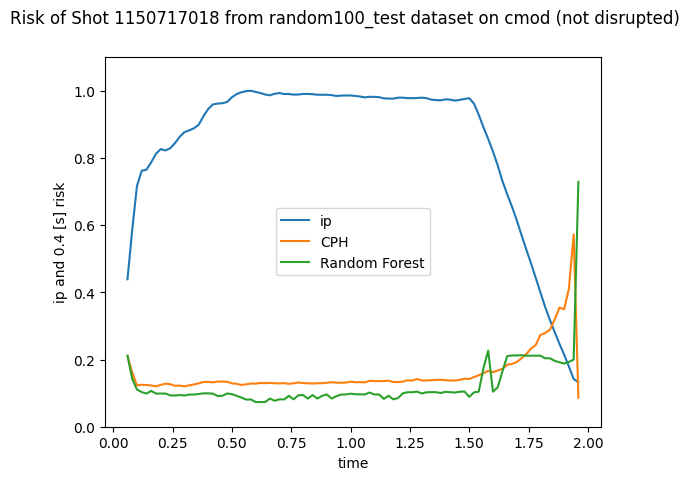

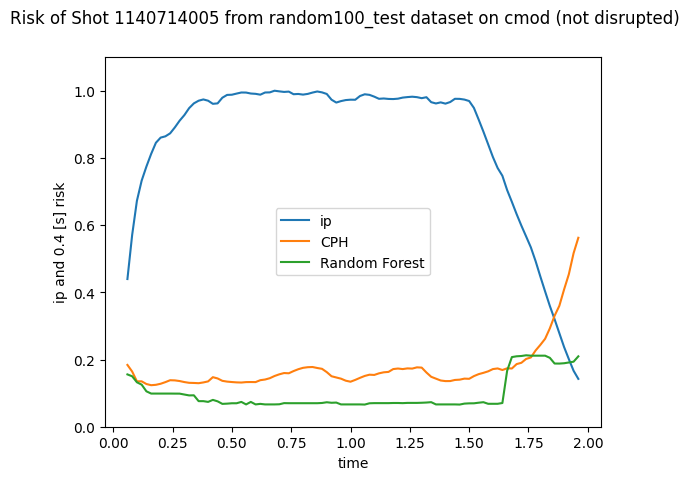

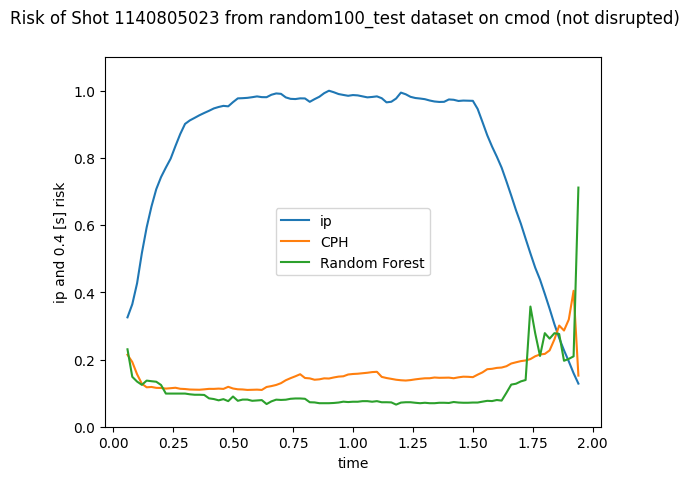

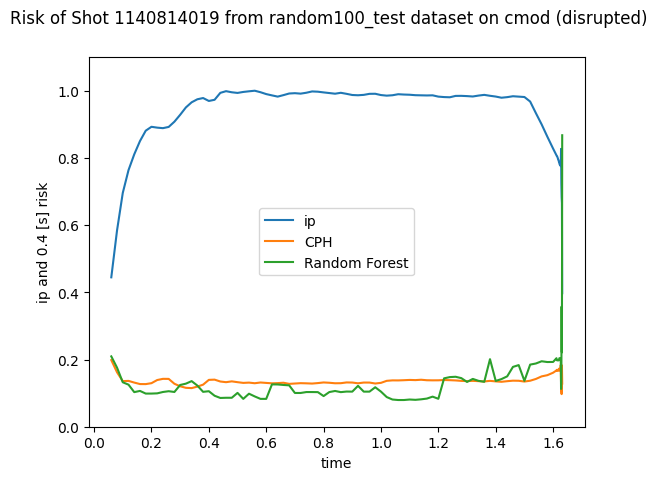

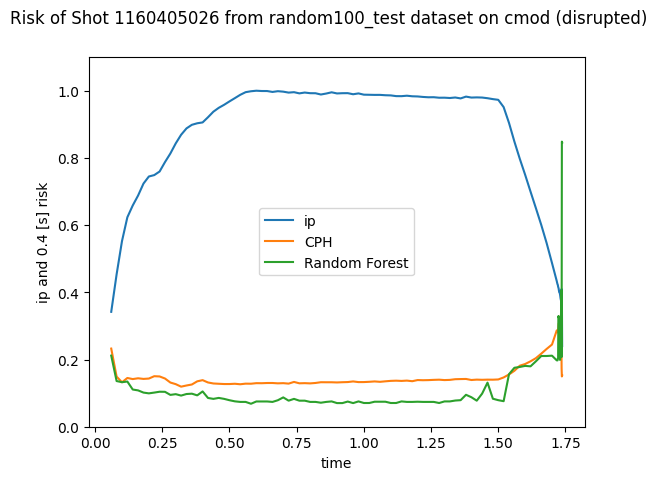

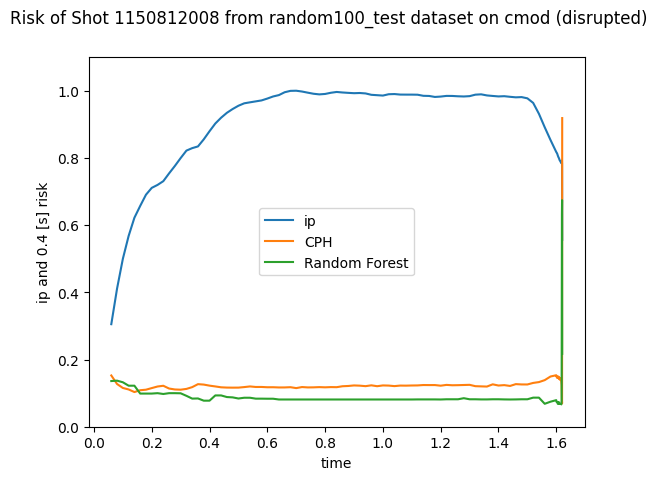

In [8]:
# Plot the performance of models with non-disruptive shots and disruptive shots
models = [cph_model, rf_model]
names = ['CPH', 'Random Forest']
for shot in non_disruptive_shot_nums[:3]:
    plot_risk(device, dataset+'_test', int(shot), 0.4, models, names, transformer)
for shot in disruptive_shot_nums[:3]:
    plot_risk(device, dataset+'_test', int(shot), 0.4, models, names, transformer)

In [ ]:
import dill

# save rsf model
dill.dump(rsf_model, open('models/rsf_model.pkl', 'wb'))